# Full phase prediction

In this notebook we investigate the model perfomance when jointly predicting the full indicator vector of phase occurences. As usually we start with some global imports and fixation of a random seed for reproducibility of results.

In [1]:
import pandas as pd
import numpy as np

STATE = np.random.RandomState(seed=1000)

## Data and Models

Thus, we have a response matrix with three columns indicating presence of 'sphere', 'worm', and 'vesicle', respectively. We ignore other phases.

In [2]:
import data1
x = data1.x
y = data1.y.filter(['sphere', 'worm', 'vesicle'], axis=1)
x.columns, y.columns

(Index(['clogp_corona', 'mon_corona_mw', 'mon_corona_apol', 'mon_corona_mv',
        'mon_corona_psa', 'dp_corona', 'corona_mw_total', 'corona_mv_total',
        'clogp_core', 'mon_core_mw', 'mon_core_apol', 'mon_core_mv',
        'mon_core_psa', 'dp_core', 'core_mw_total', 'core_mv_total',
        'ratio_mass', 'ratio_vol', 'conc', 'ph', 'salt', 'charged', 'temp',
        'core_BzMA', 'core_DAAM', 'core_EGEMA', 'core_GlyMA', 'core_HBMA',
        'core_HEMA', 'core_HPMA', 'core_MEMA', 'core_PhA', 'core_TFMA',
        'core_EGDMA', 'core_cyclic', 'corona_GMA', 'corona_MPC',
        'corona_AcETMAC', 'corona_MAA', 'corona_DMA', 'corona_PEG',
        'corona_CysMA', 'corona_GluMA', 'corona_DMAPS', 'corona_AEMA',
        'corona_QDMAEMA', 'corona_HPMAm', 'corona_KSPMA', 'corona_MAcEPyr',
        'corona_DSDMA', 'initiator_ACVA', 'initiator_AIBA',
        'initiator_KPS/AscAc', 'initiator_V-501', 'initiator_VA-044',
        'initiator_tBH-Na2SO3'],
       dtype='object'),
 Index(['sphere', 

For modelling, we focus on the best performing model for the indiviudal phases, the random forest model.

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain

rf = RandomForestClassifier(random_state=STATE, min_samples_leaf=1, n_estimators=100)

rf_ind = MultiOutputClassifier(rf)
rf_chain = ClassifierChain(rf, order=[0, 2, 1])

# Extrapolation performance



In [4]:
from common import ExtrapolationExperiment
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score
import data

extrapolation = ExtrapolationExperiment([rf_ind, rf_chain], 
                                        ['RF_ind', 'RF_chain'],
                                        x, y, data1.comp_ids).run()

Running experiment with 37 repetitions
*************************************


In [6]:
extrapolation.summary()

,mean_train_accuracy,std_train_accuracy,mean_test_accuracy,std_test_accuracy,mean_train_size,std_train_size,mean_test_size,std_test_size
RF_ind,0.998354,0.000289,0.631422,0.407337,591.567568,23.955445,16.432432,23.955445
RF_chain,0.998354,0.000289,0.655042,0.388972,591.567568,23.955445,16.432432,23.955445


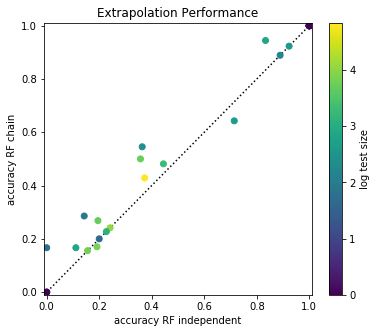

In [43]:
from matplotlib import pyplot as plt
from numpy import log

fig, ax = plt.subplots(figsize=(6, 5))
plt.plot([-0.05, 1.05], [-0.05, 1.05], linestyle=':', color='black', zorder=-1)
scatter = ax.scatter(
    extrapolation.results_[extrapolation.results_.estimator == 'RF_ind']['test_accuracy'], 
    extrapolation.results_[extrapolation.results_.estimator == 'RF_chain']['test_accuracy'],
    marker='o', c=log(extrapolation.results_[extrapolation.results_.estimator == 'RF_ind']['test_size'].astype('int')))
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
plt.xlabel('accuracy RF independent')
plt.ylabel('accuracy RF chain')
plt.title('Extrapolation Performance')
plt.colorbar(scatter, label='log test size')
plt.show()